In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline
sys.path.append(os.path.abspath(".."))

# Import the correct functions

from src.data_loader import load_news_data, load_stock_files
from src.strategy_utils import merge_sentiment_all_stocks
from src.nlp_utils import extract_sentiment


In [2]:

#  Correct path from notebooks/ to Data/
news_path = "../Data/raw_analyst_ratings.csv"
news_df = load_news_data(news_path)
news_df = extract_sentiment(news_df)
# Preview
news_df[["headline", "polarity"]].head()

news_df[["headline", "polarity"]].tail()


,headline,polarity
1407323,Top Narrow Based Indexes For August 29,0.15
1407324,Recap: Wednesday's Top Percentage Gainers and ...,0.15
1407325,UPDATE: Oppenheimer Color on China Zenix Auto ...,0.00
1407326,Oppenheimer Initiates China Zenix At Outperfor...,0.00
1407327,China Zenix Auto International Opens For Tradi...,0.00


In [3]:
stock_data = load_stock_files("../Data/yfinance_data/")

In [4]:
#checking sentiment date coverage from when to when
#If stock prices go up to 2024-07-30, but news data only goes up to 2024-06-30, then:
#avg_sentiment will be NaN for July
news_df["date"].min(), news_df["date"].max()

('2009-02-14 00:00:00', '2020-06-11 17:12:35-04:00')

In [5]:
#What it does:
#Converts each headline’s date to YYYY-MM-DD
#Computes average sentiment per date
#Joins that sentiment onto each stock’s price data by date
#To merge daily sentiment (avg_sentiment) into each stock’s historical DataFrame.
merged_data = merge_sentiment_all_stocks(news_df, stock_data)
#checking overlap time between news and stock


In [6]:
merged_data["AAPL"].columns
# ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'date', 'avg_sentiment']


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'date',
       'avg_sentiment'],
      dtype='object')

In [7]:
merged_data["AAPL"]["date"].min(), merged_data["AAPL"]["date"].max()
#merged_data["AAPL"][["date", "Close", "avg_sentiment"]].tail()

(datetime.date(1980, 12, 12), datetime.date(2024, 7, 30))

In [8]:
#now thi will check aggregated sentiment date between news and stock data
news_df.groupby("date")["polarity"].mean().reset_index().head()


,date,polarity
0,2009-02-14 00:00:00,0.000000
1,2009-04-27 00:00:00,0.000000
2,2009-04-29 00:00:00,0.000000
3,2009-05-22 00:00:00,0.000000
4,2009-05-27 00:00:00,0.234091


In [9]:
#now thi will check aggregated sentiment date between news and stock data
news_df.groupby("date")["polarity"].mean().reset_index().tail()


,date,polarity
39952,2020-06-11 16:49:41-04:00,0.000000
39953,2020-06-11 16:51:33-04:00,0.000000
39954,2020-06-11 17:01:39-04:00,-0.085185
39955,2020-06-11 17:11:20-04:00,0.000000
39956,2020-06-11 17:12:35-04:00,0.000000


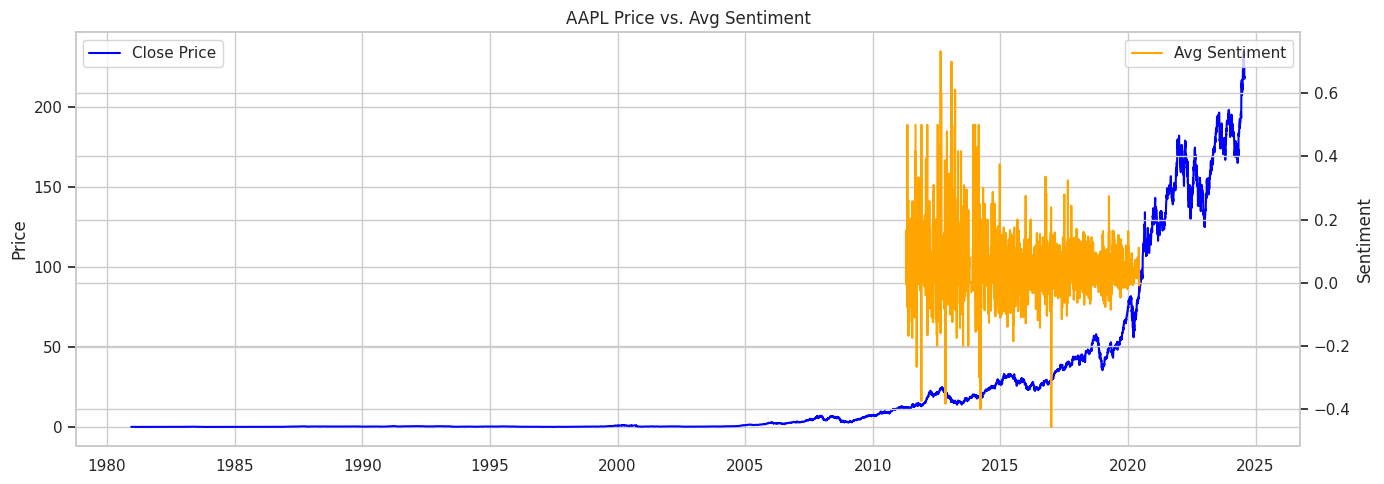

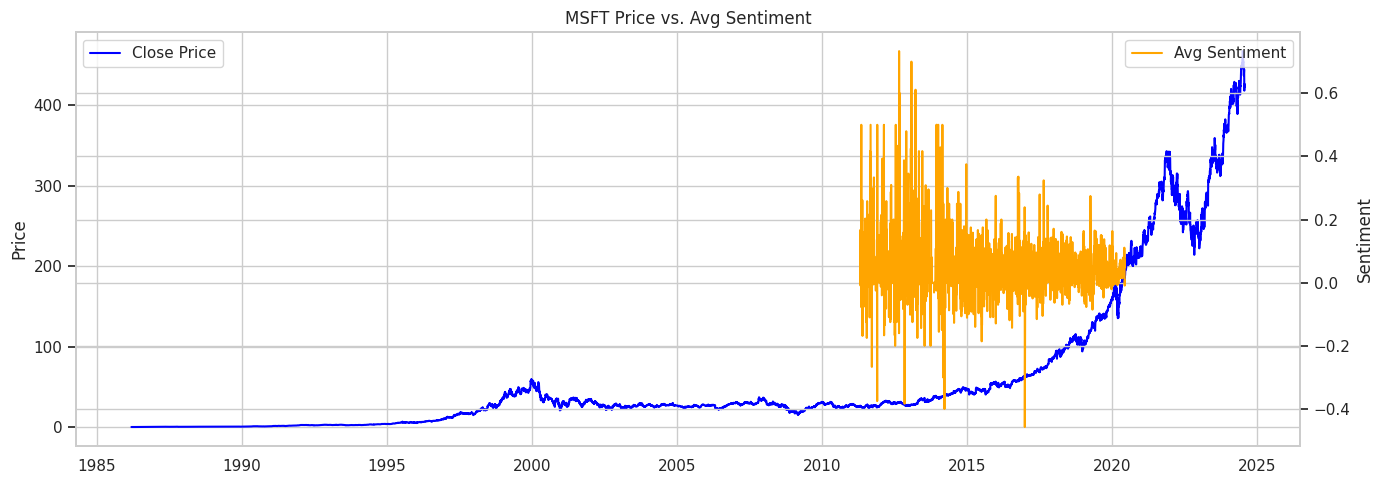

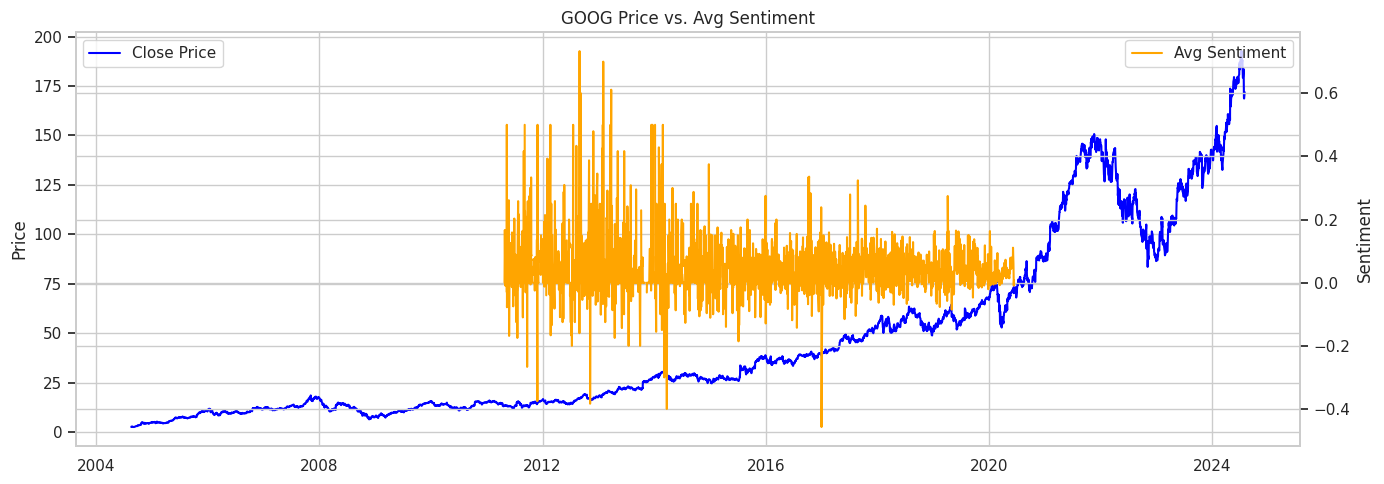

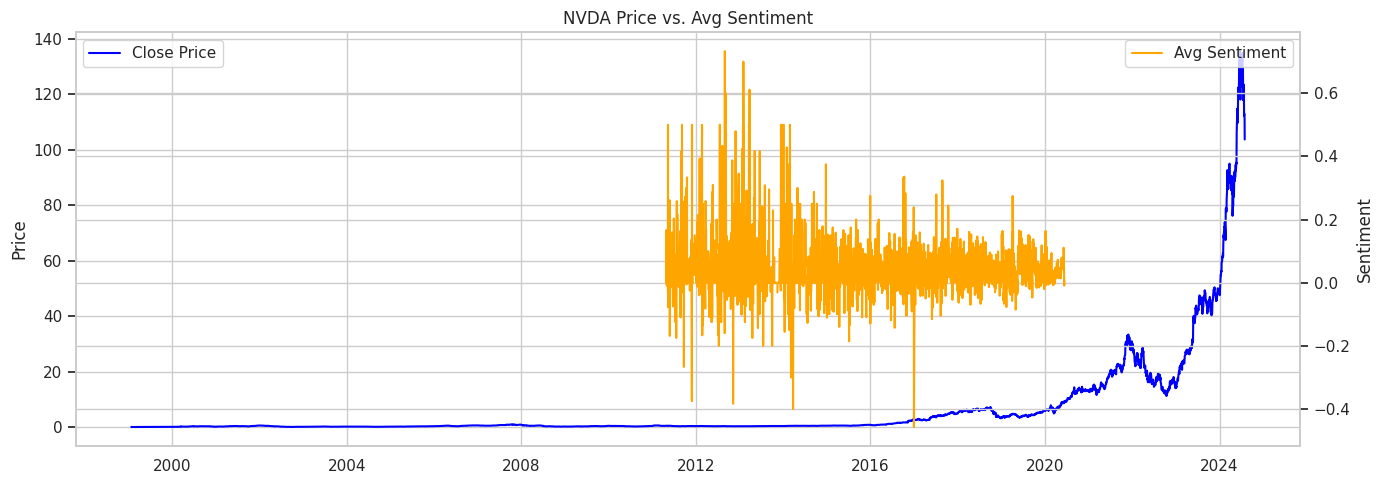

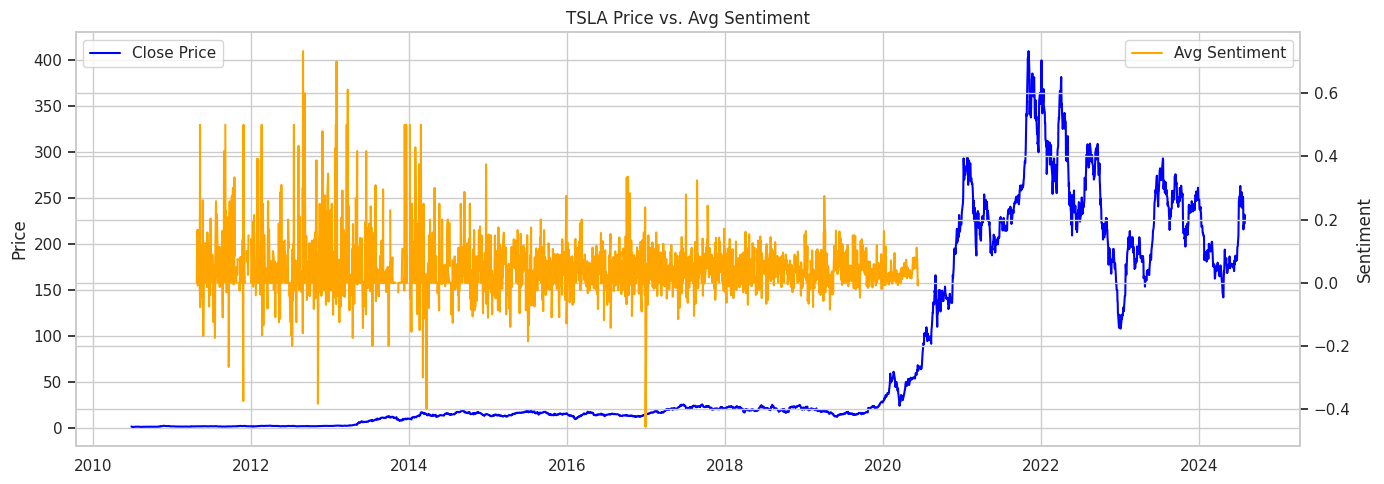

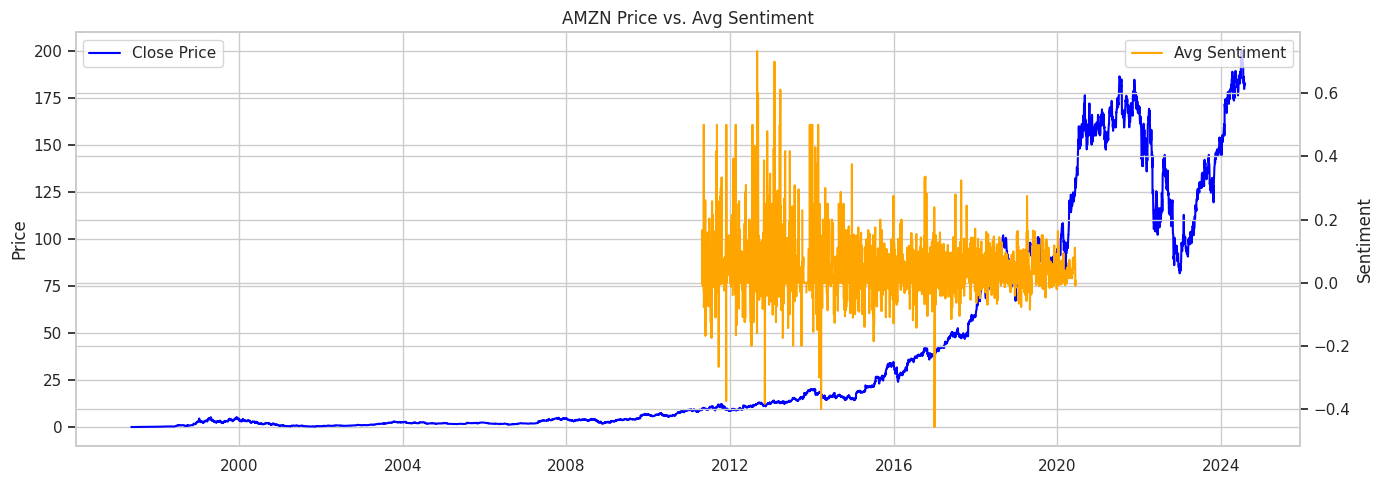

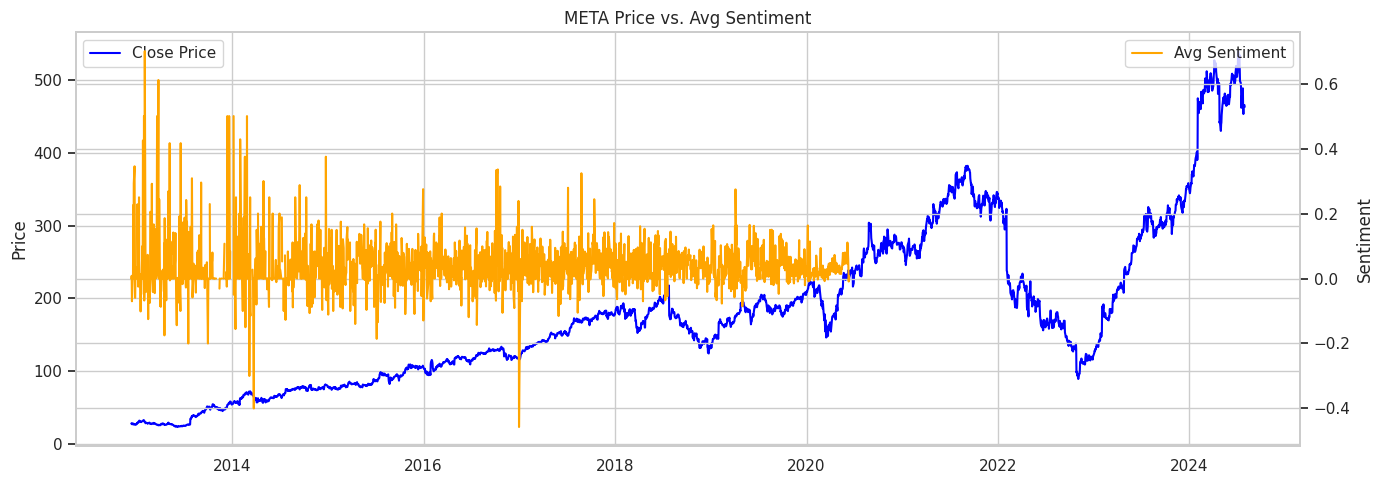

In [10]:
import matplotlib.pyplot as plt

for company, df in merged_data.items():
    fig, ax1 = plt.subplots(figsize=(14, 5))

    ax1.set_title(f"{company} Price vs. Avg Sentiment")
    ax1.plot(df["date"], df["Close"], color='blue', label='Close Price')
    ax2 = ax1.twinx()
    ax2.plot(df["date"], df["avg_sentiment"], color='orange', label='Avg Sentiment')
    ax1.set_ylabel("Price")
    ax2.set_ylabel("Sentiment")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [11]:
# step two corroletion analysis 
#Quantify the relationship between news sentiment (avg_sentiment) and stock returns (returns) for each of your 7 companies.
#add daily return column 
df["returns"] = df["Close"].pct_change()


In [12]:
#compute pearson correlatin
df[["avg_sentiment", "returns"]].corr().iloc[0, 1]


np.float64(-0.006069691850633905)

In [13]:
#lets loop over 7 companiees 
correlations = {}

for ticker, df in merged_data.items():
    df = df.copy()
    df["returns"] = df["Close"].pct_change()
    
    # Drop missing sentiment or return rows
    corr_df = df.dropna(subset=["avg_sentiment", "returns"])
    
    if not corr_df.empty:
        corr = corr_df[["avg_sentiment", "returns"]].corr().iloc[0, 1]
        correlations[ticker] = round(corr, 4)
    else:
        correlations[ticker] = None

# Show result
print(" Correlation between avg_sentiment and returns:\n")
for ticker, corr in correlations.items():
    print(f"{ticker}: {corr}")


 Correlation between avg_sentiment and returns:

AAPL: -0.002
MSFT: -0.0128
GOOG: 0.0143
NVDA: 0.0093
TSLA: 0.0277
AMZN: -0.0194
META: -0.0061


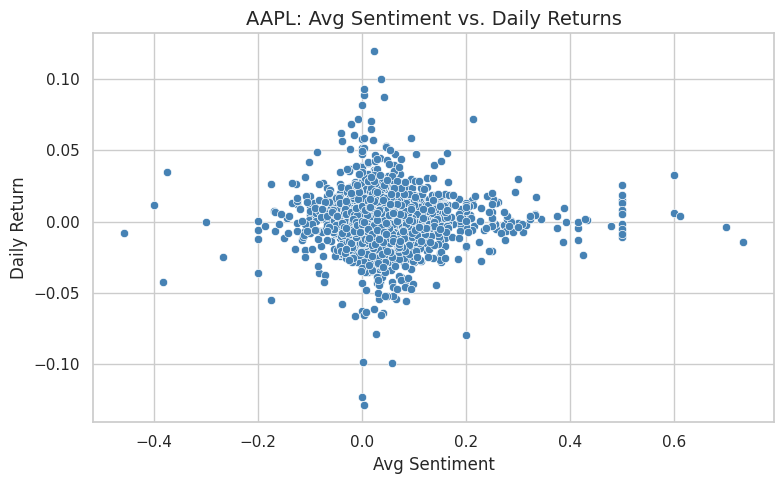

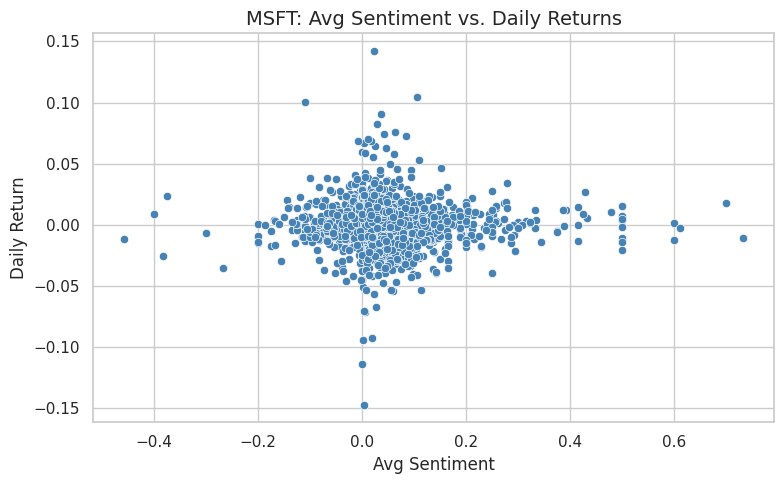

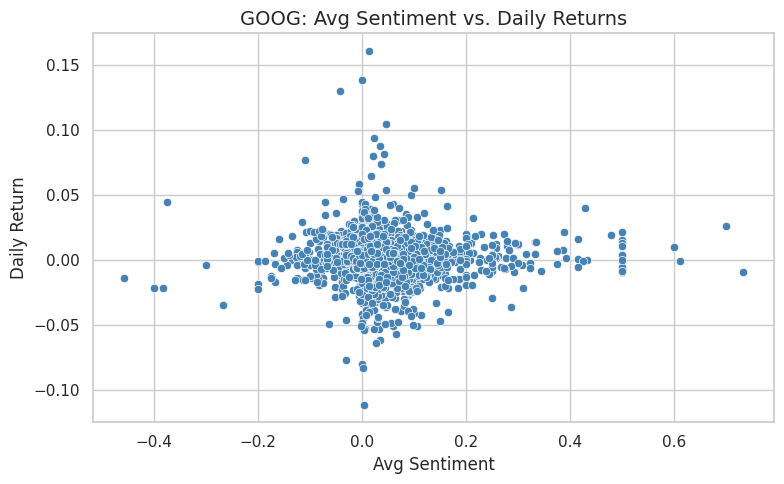

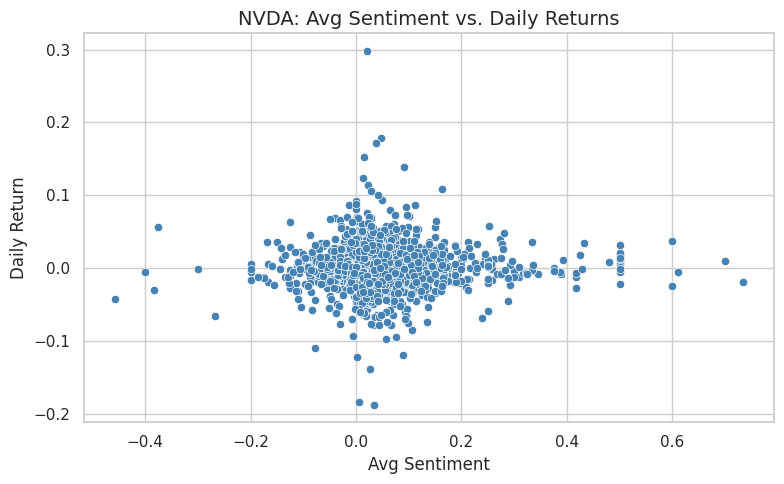

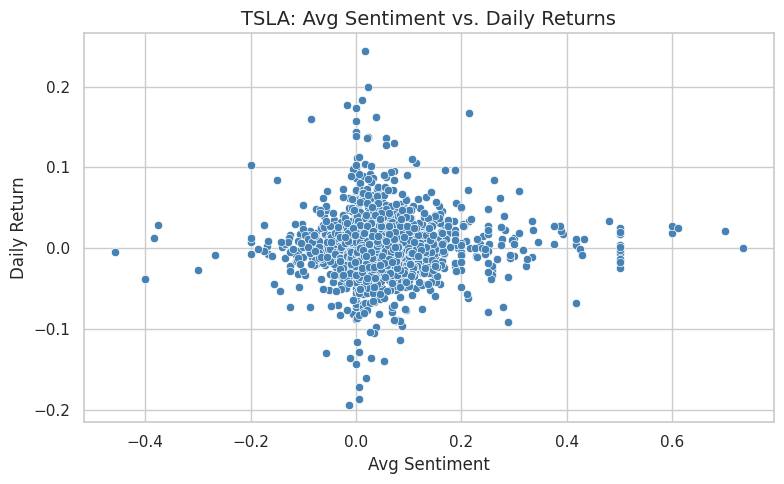

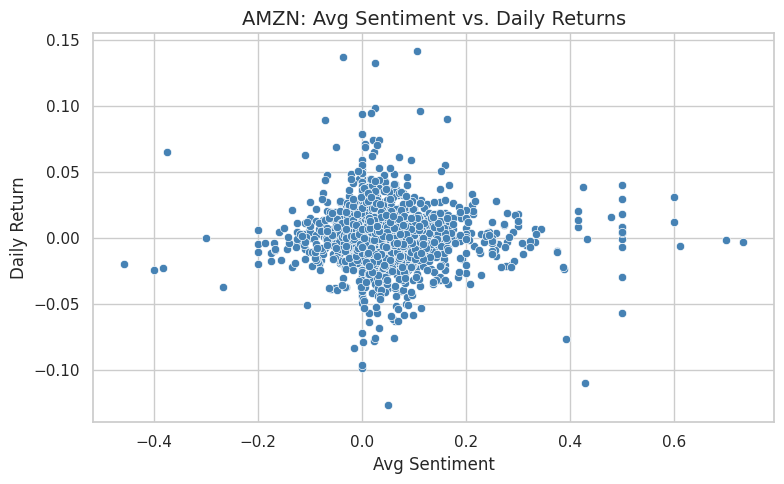

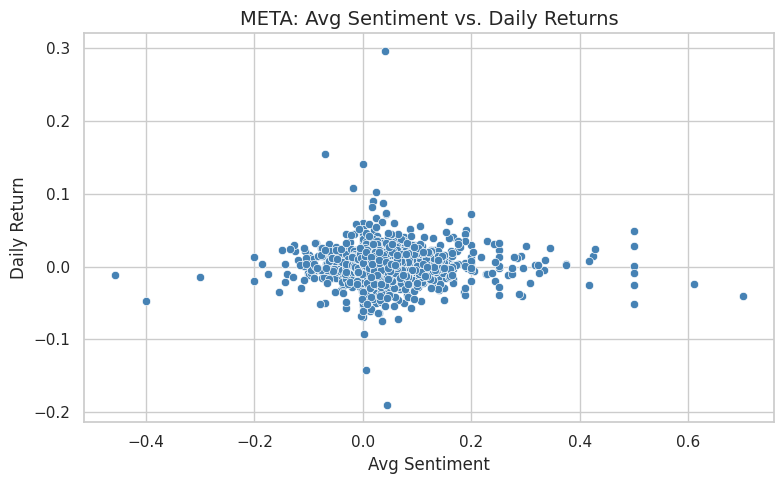

In [14]:
#visualize correleation 
import seaborn as sns
import matplotlib.pyplot as plt

# Set global style
sns.set(style="whitegrid")

# Loop through all tickers in merged_data
for ticker, df in merged_data.items():
    df = df.copy()
    df["returns"] = df["Close"].pct_change()
    
    # Drop rows with missing values
    df = df.dropna(subset=["returns", "avg_sentiment"])
    
    if df.empty:
        print(f"Skipping {ticker} due to no valid data.")
        continue

    # Plot
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x="avg_sentiment", y="returns", color="steelblue")
    plt.title(f"{ticker}: Avg Sentiment vs. Daily Returns", fontsize=14)
    plt.xlabel("Avg Sentiment")
    plt.ylabel("Daily Return")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [15]:
# generate trading signal 
#Use technical indicators (MACD, RSI, MA20) and sentiment (avg_sentiment) to define Buy/Sell rules and generate trading signals.
# so lets add technical indicators 
from src.ta_indicators import add_technical_indicators

for ticker in merged_data:
    merged_data[ticker] = add_technical_indicators(merged_data[ticker])


In [16]:
#define signal logic
def generate_signals(df, sentiment_threshold=0.1):
    df = df.copy()

    # Safety check
    required_cols = {"RSI", "MACD", "MACD_Signal", "avg_sentiment", "Adj Close"}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Missing required columns: {required_cols - set(df.columns)}")

    # MACD crossover logic
    df["MACD_Cross_Up"] = (df["MACD"] > df["MACD_Signal"]) & (df["MACD"].shift(1) <= df["MACD_Signal"].shift(1))
    df["MACD_Cross_Down"] = (df["MACD"] < df["MACD_Signal"]) & (df["MACD"].shift(1) >= df["MACD_Signal"].shift(1))

    # Strategy logic
    df["Buy_Signal"] = (df["MACD_Cross_Up"]) & (df["avg_sentiment"] > sentiment_threshold)
    df["Sell_Signal"] = (df["MACD_Cross_Down"]) & (df["avg_sentiment"] < -sentiment_threshold)

    return df


In [17]:
#apply signla generator 
for ticker in merged_data:
    merged_data[ticker] = generate_signals(merged_data[ticker])


 Plotting Buy/Sell signals for AAPL...


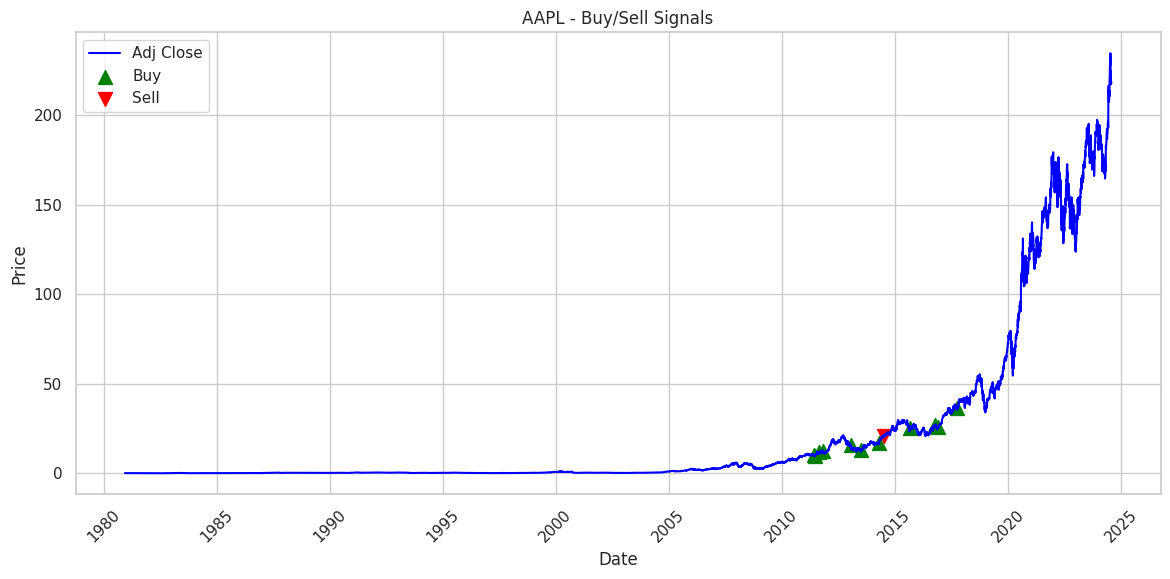

 Plotting Buy/Sell signals for MSFT...


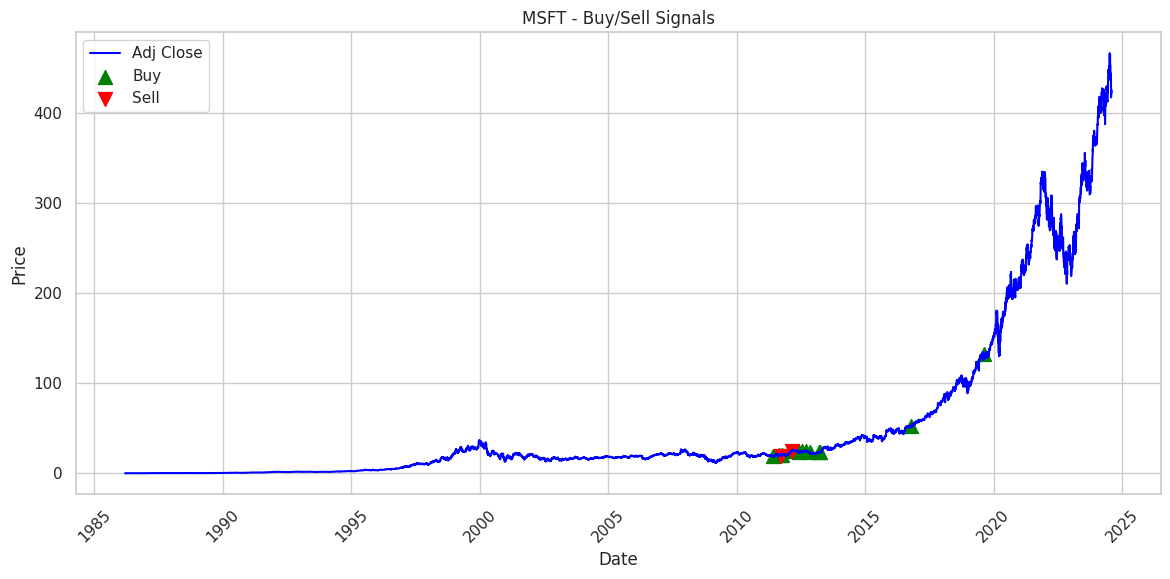

 Plotting Buy/Sell signals for GOOG...


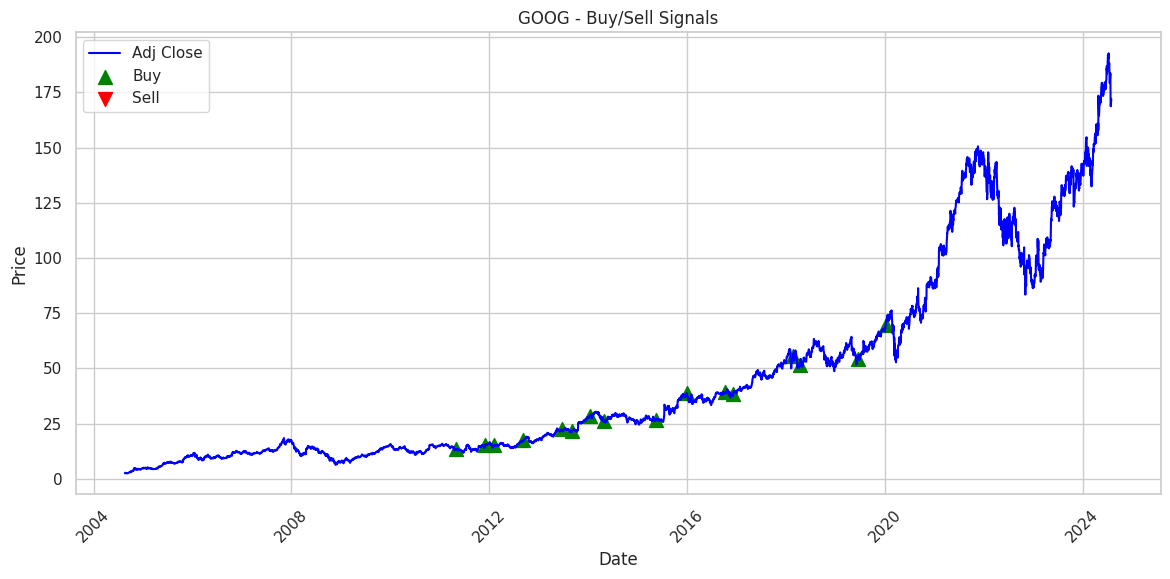

 Plotting Buy/Sell signals for NVDA...


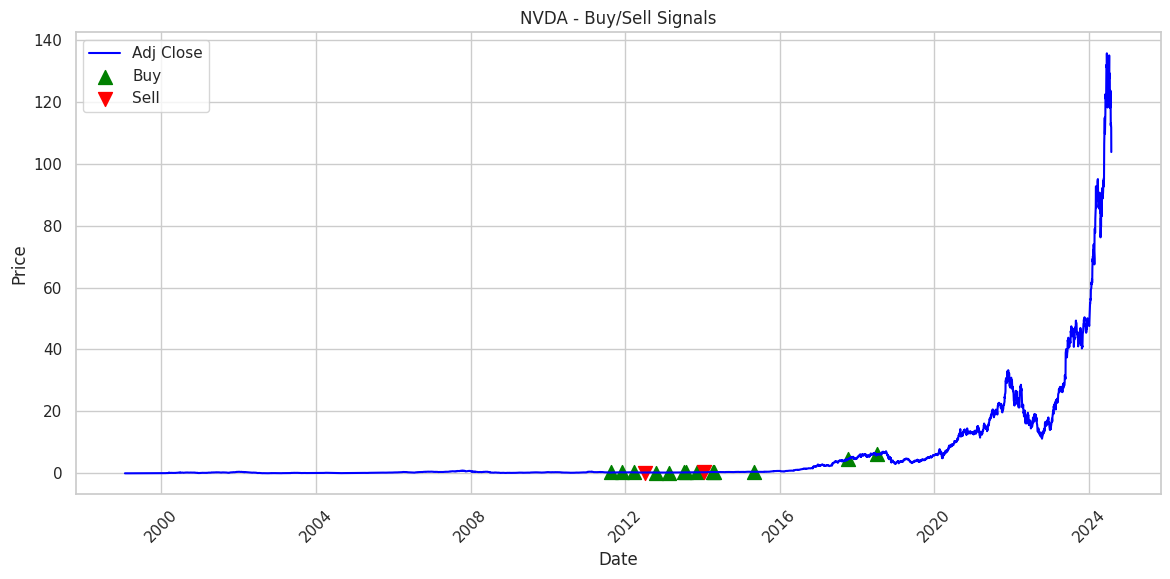

 Plotting Buy/Sell signals for TSLA...


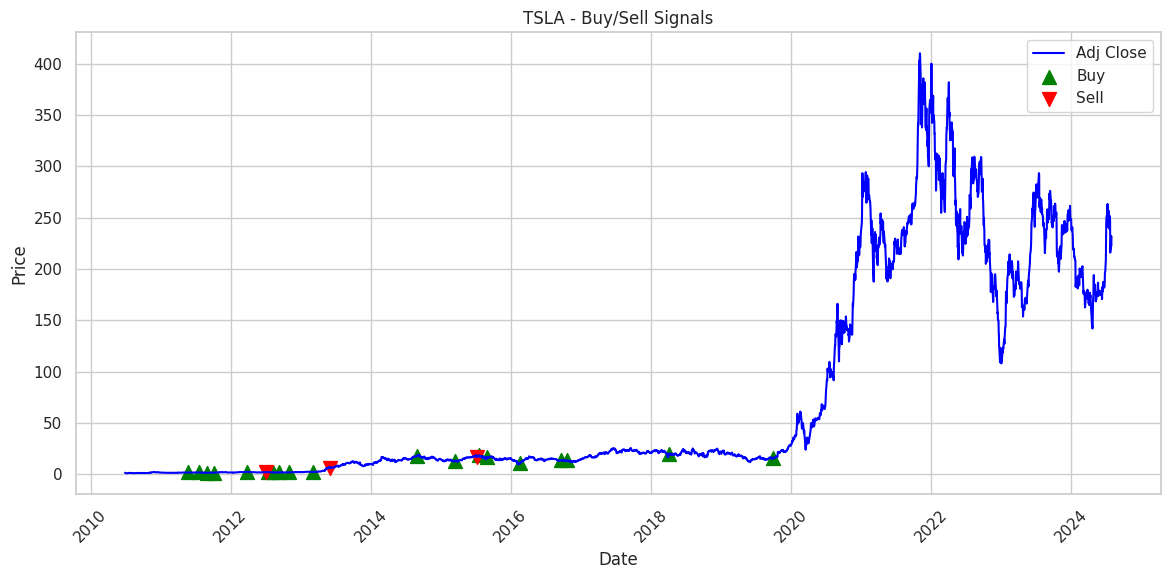

 Plotting Buy/Sell signals for AMZN...


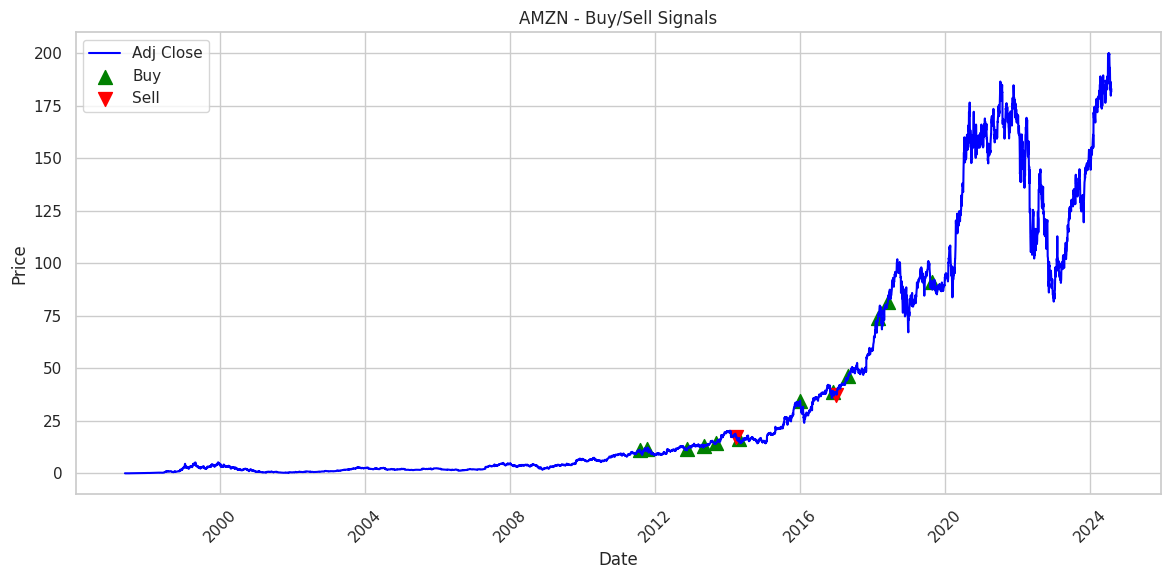

 Plotting Buy/Sell signals for META...


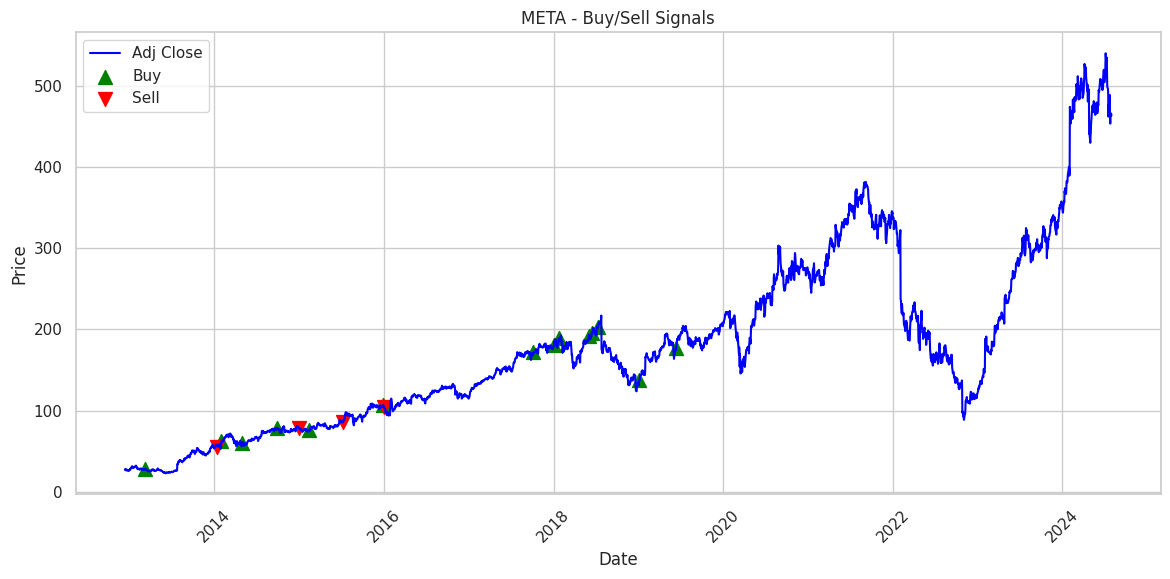

In [18]:
#plot signal for each companies 
from src.visualizer import plot_trade_signals

# Loop over each stock in the merged_data dictionary
for ticker, df in merged_data.items():
    print(f" Plotting Buy/Sell signals for {ticker}...")
    plot_trade_signals(df, ticker)


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

def plot_signal_dashboard(ticker, df):
    df = df.copy()
    df["returns"] = df["Close"].pct_change()
    df = df.dropna(subset=["returns", "avg_sentiment"])

    fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    fig.suptitle(f"{ticker} — Nova Strategy Dashboard", fontsize=16)


    # 1️ Plot price with signals
    axs[0].plot(df.index, df["Adj Close"], label="Adj Close", color="blue")
    axs[0].scatter(df[df["Buy_Signal"]].index, df[df["Buy_Signal"]]["Adj Close"],
                   marker="^", color="green", label="Buy", s=100)
    axs[0].scatter(df[df["Sell_Signal"]].index, df[df["Sell_Signal"]]["Adj Close"],
                   marker="v", color="red", label="Sell", s=100)
    axs[0].set_title("Price with Buy/Sell Signals")
    axs[0].legend()
    axs[0].grid(True)

    # 2 Plot sentiment vs returns
    sns.scatterplot(x="avg_sentiment", y="returns", data=df, ax=axs[1], color="orange")
    axs[1].set_title("Sentiment vs. Returns")
    axs[1].set_xlabel("Avg Sentiment")
    axs[1].set_ylabel("Daily Return")
    axs[1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


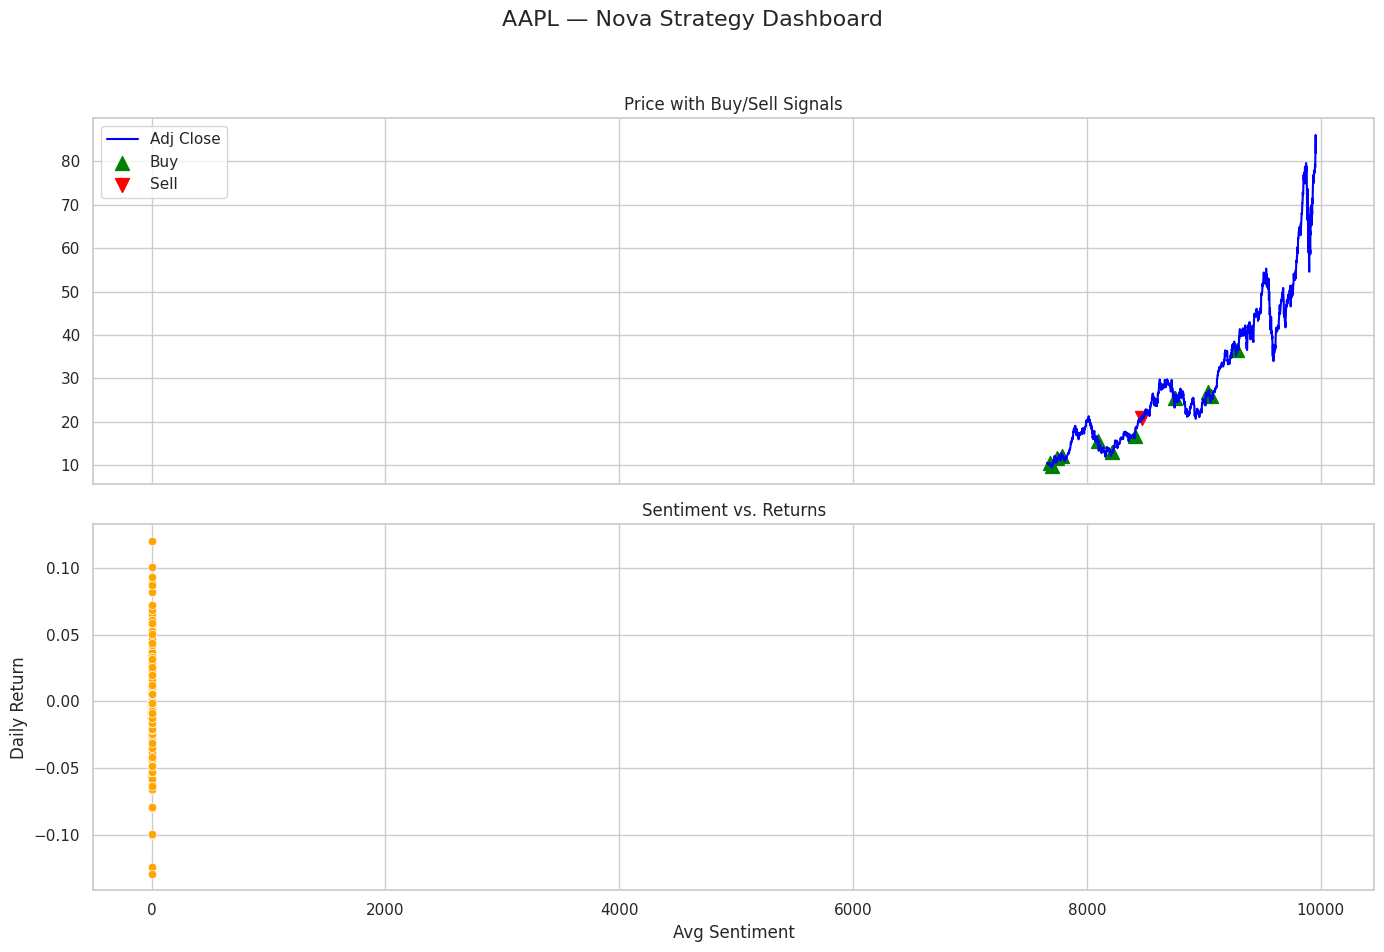

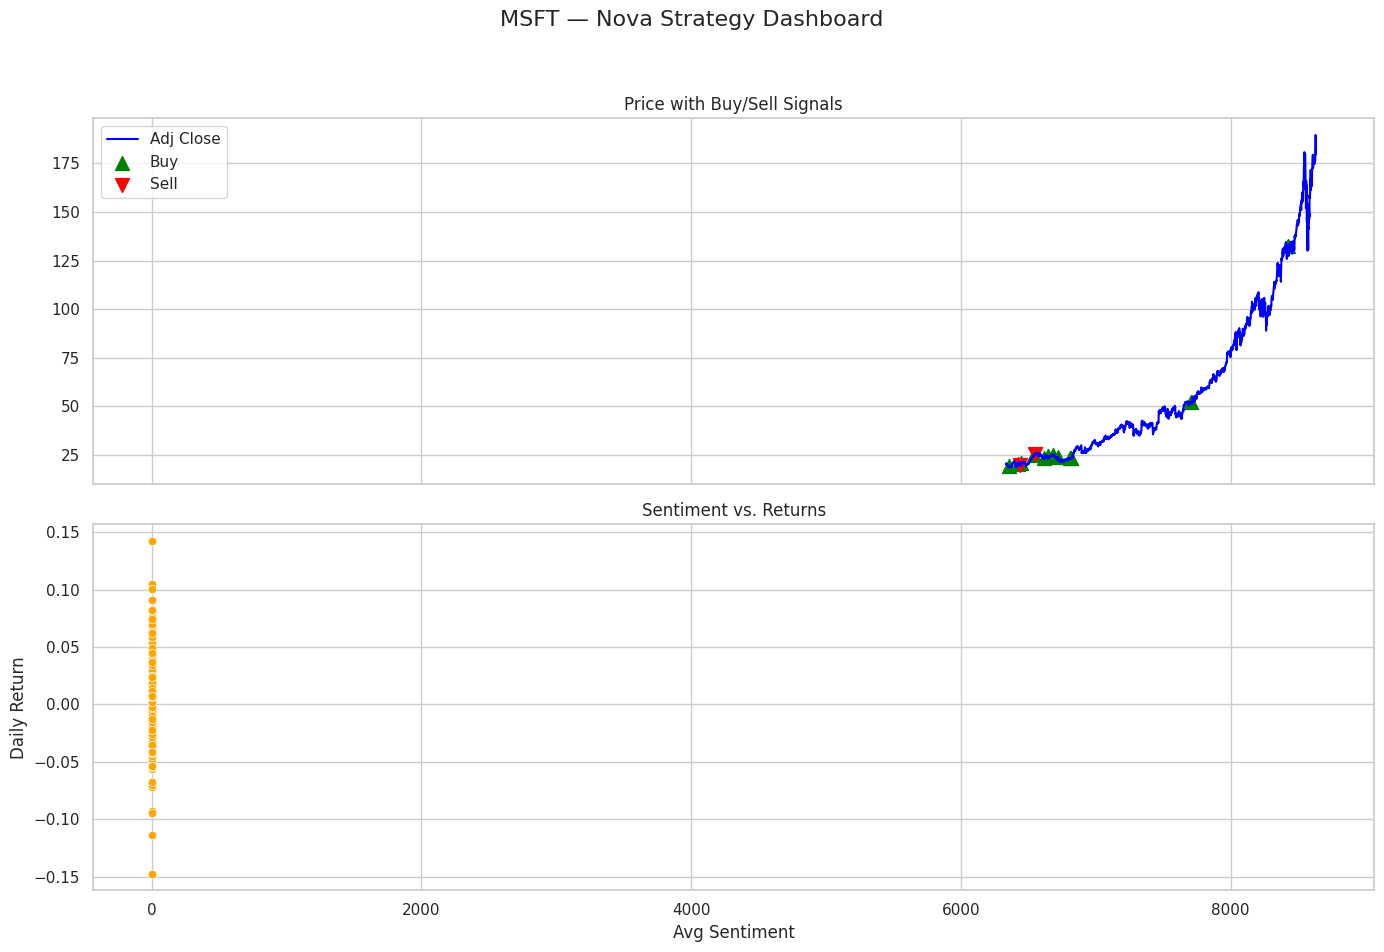

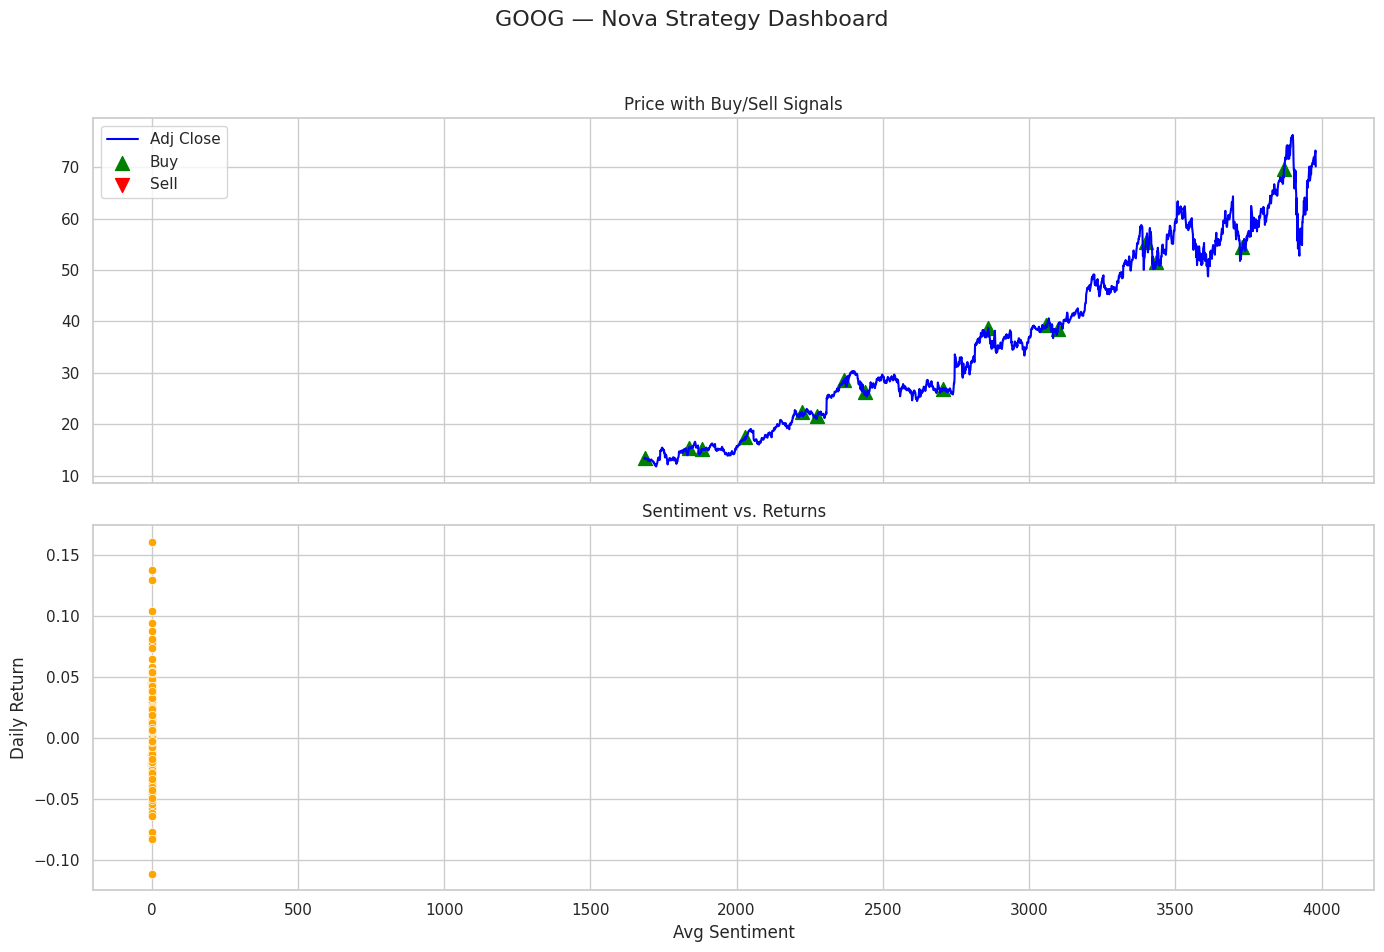

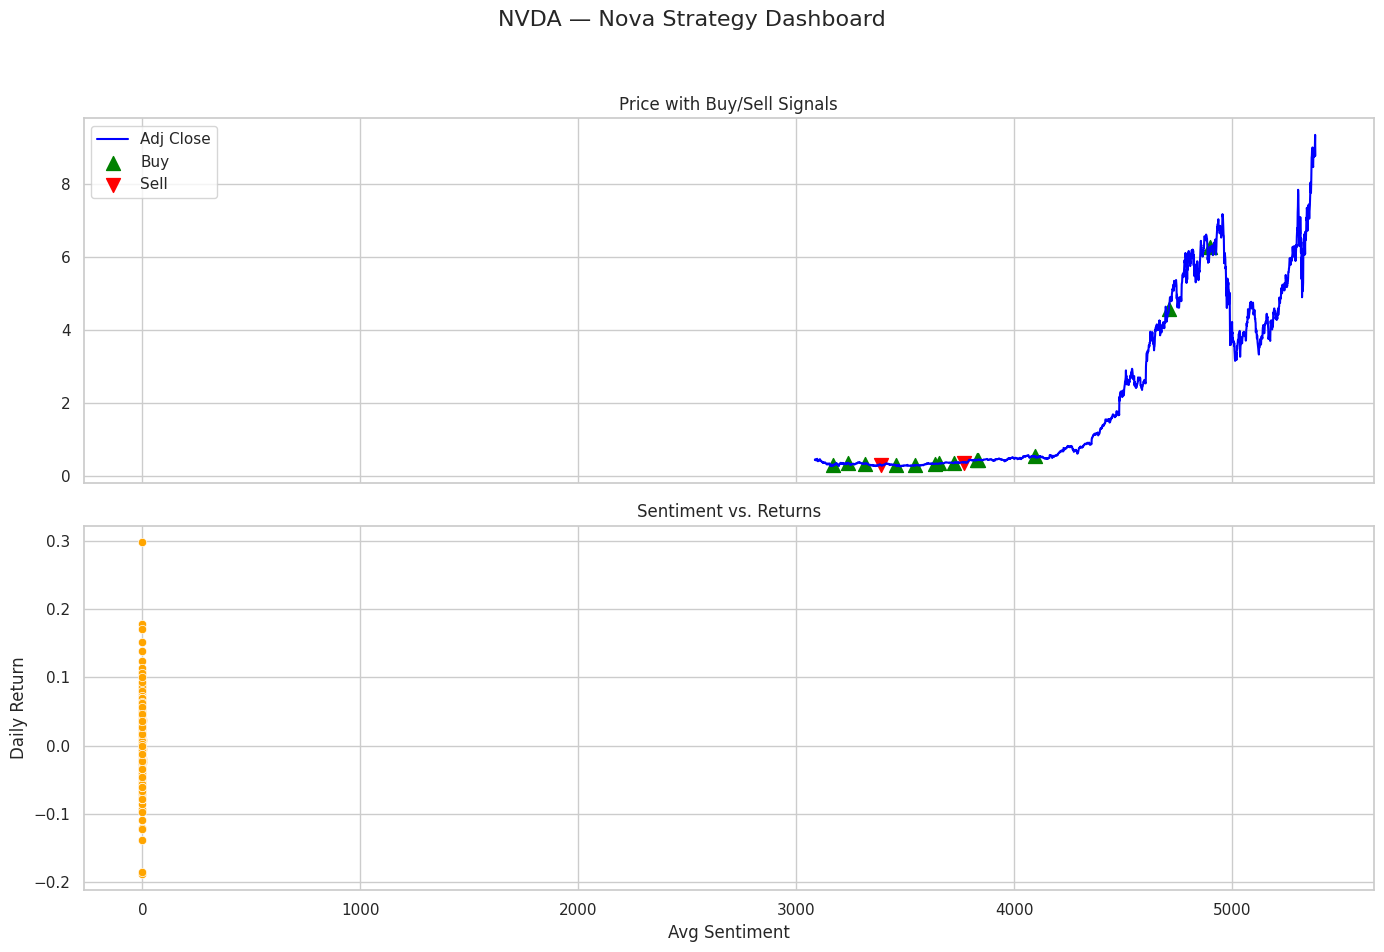

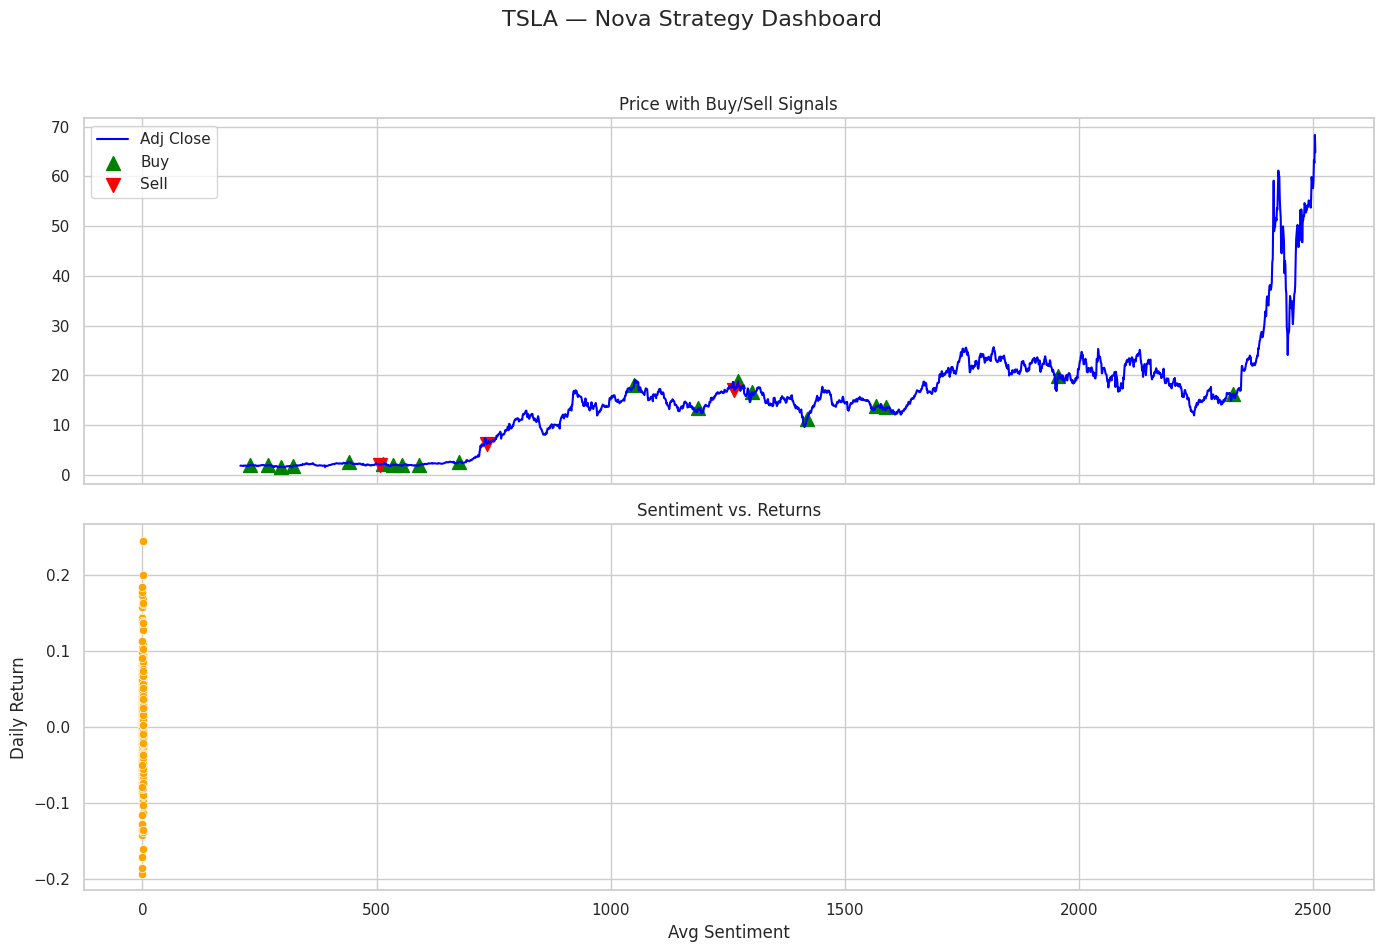

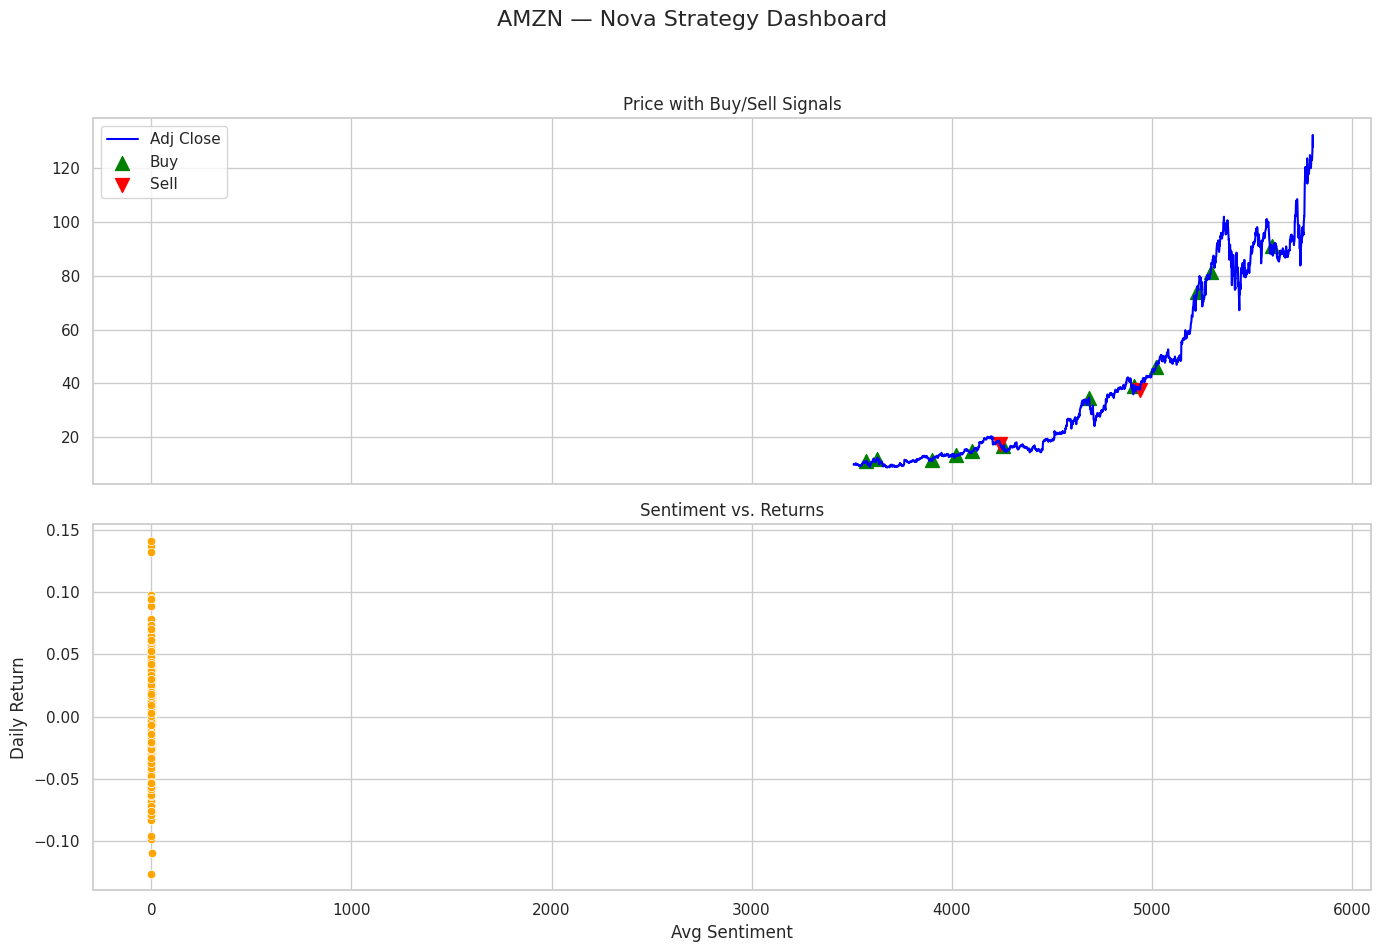

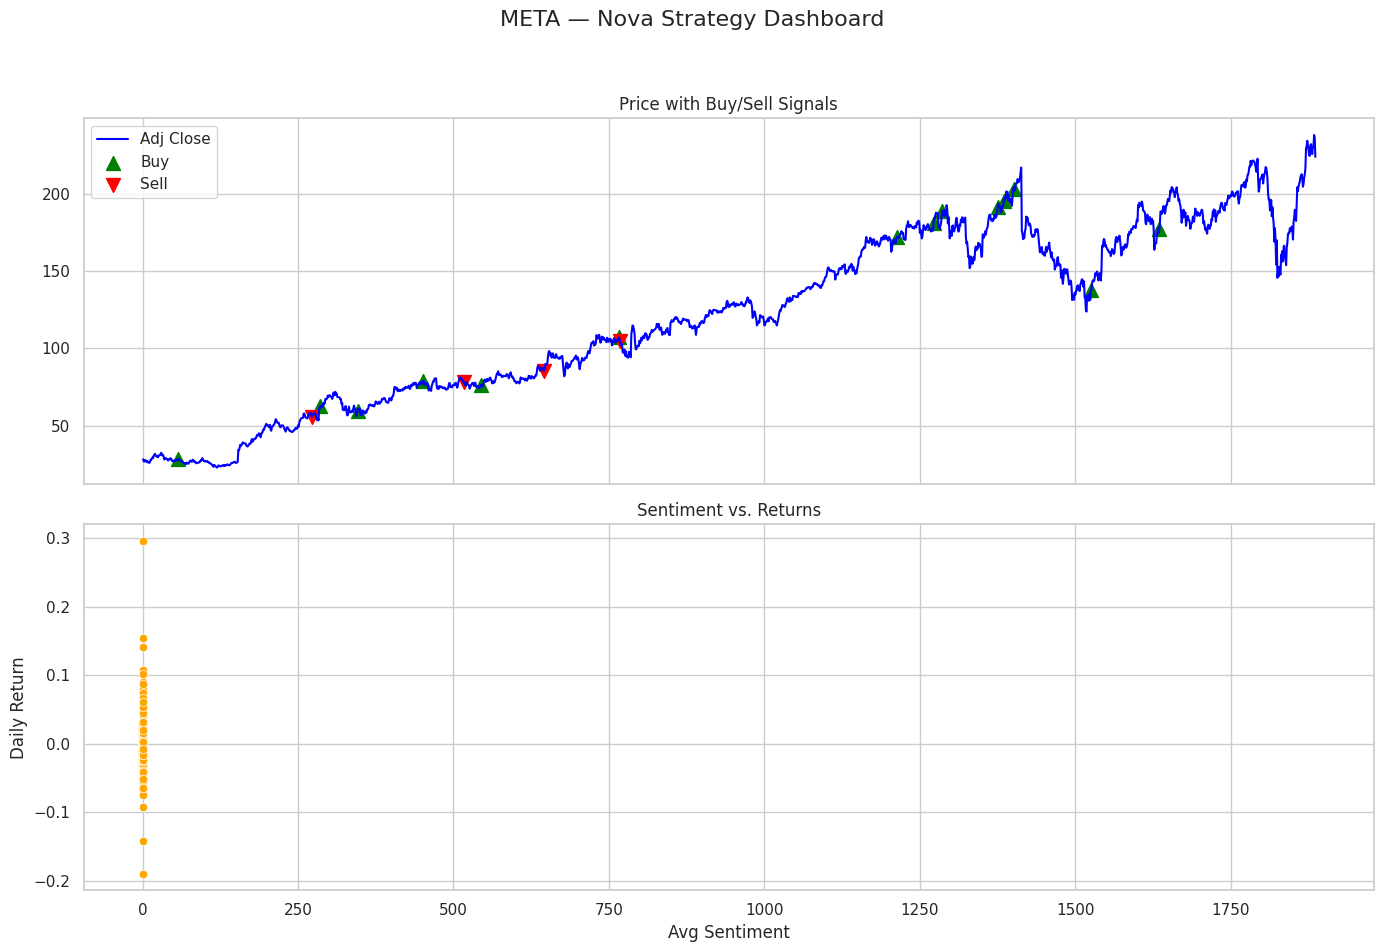

In [27]:
for ticker in merged_data:
    plot_signal_dashboard(ticker, merged_data[ticker])


 AAPL:
   Total rows: 10998
   Missing avg_sentiment: 8772
   Missing returns: 1
   Rows available for correlation: 2226


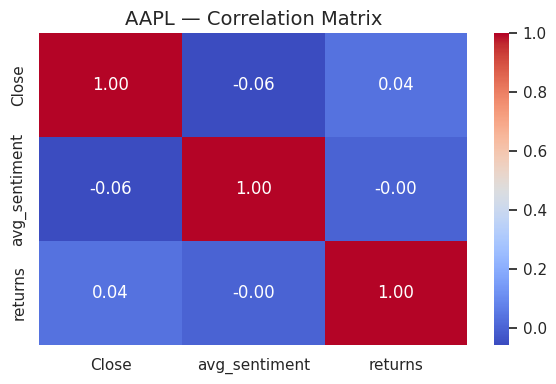

 MSFT:
   Total rows: 9672
   Missing avg_sentiment: 7446
   Missing returns: 1
   Rows available for correlation: 2226


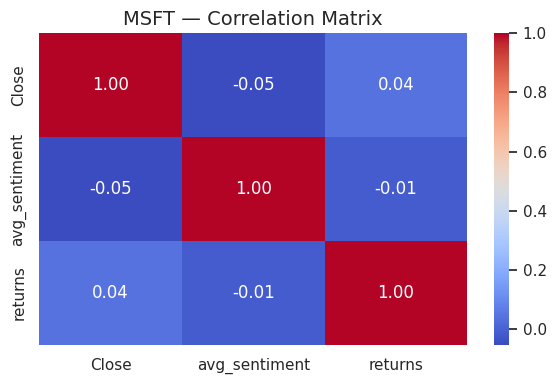

 GOOG:
   Total rows: 5020
   Missing avg_sentiment: 2794
   Missing returns: 1
   Rows available for correlation: 2226


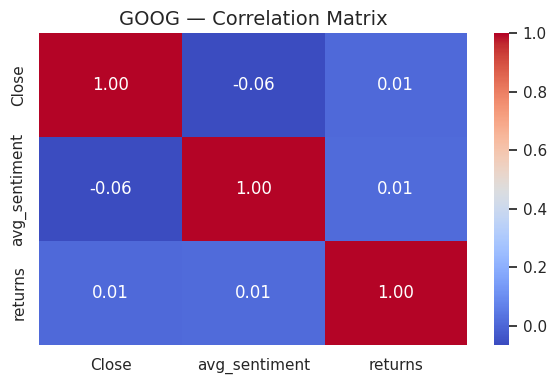

 NVDA:
   Total rows: 6421
   Missing avg_sentiment: 4195
   Missing returns: 1
   Rows available for correlation: 2226


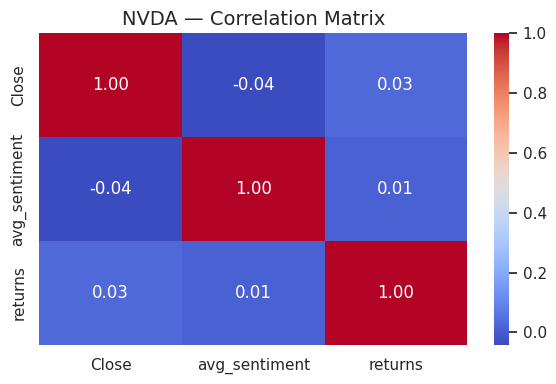

 TSLA:
   Total rows: 3545
   Missing avg_sentiment: 1319
   Missing returns: 1
   Rows available for correlation: 2226


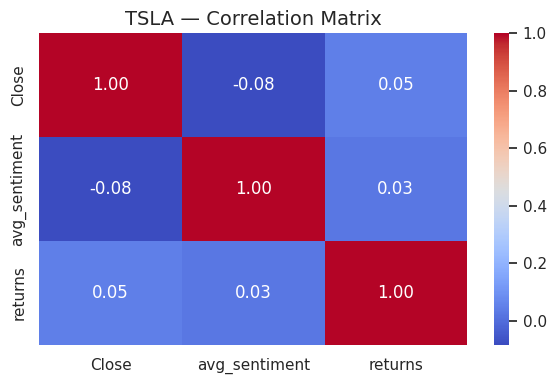

 AMZN:
   Total rows: 6846
   Missing avg_sentiment: 4620
   Missing returns: 1
   Rows available for correlation: 2226


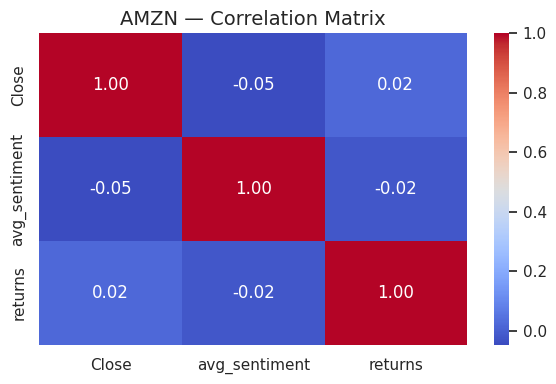

 META:
   Total rows: 2926
   Missing avg_sentiment: 1078
   Missing returns: 1
   Rows available for correlation: 1847


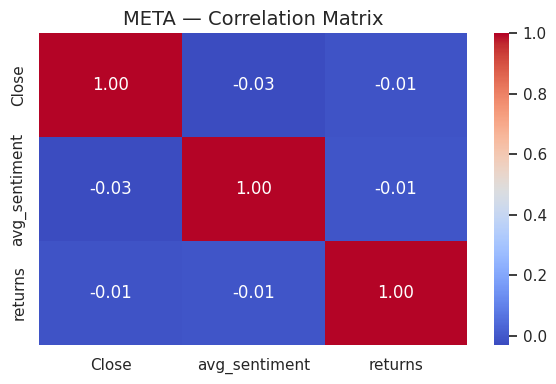

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrix(df, ticker):
    df = df.copy()
    df["returns"] = df["Close"].pct_change()
    
    # Diagnostic: check missing values
    total_rows = len(df)
    sentiment_missing = df["avg_sentiment"].isna().sum()
    returns_missing = df["returns"].isna().sum()
    available_rows = df[["Close", "avg_sentiment", "returns"]].dropna().shape[0]

    print(f" {ticker}:")
    print(f"   Total rows: {total_rows}")
    print(f"   Missing avg_sentiment: {sentiment_missing}")
    print(f"   Missing returns: {returns_missing}")
    print(f"   Rows available for correlation: {available_rows}")

    # Check if enough data to visualize
    if available_rows < 5:
        print(f" Skipping {ticker} — Not enough valid rows for correlation matrix.\n")
        return

    # Plot correlation matrix
    subset = df[["Close", "avg_sentiment", "returns"]].dropna()
    corr = subset.corr()

    plt.figure(figsize=(6, 4))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"{ticker} — Correlation Matrix", fontsize=14)
    plt.tight_layout()
    plt.show()

#  Run for all companies
for ticker, df in merged_data.items():
    plot_correlation_matrix(df, ticker)
